# Proyecto final Inteligencia Computacional
## Style Transfer
### [Ammi Beltrán Troppa, Fernanda Borja Muñoz]

# Imports

In [1]:
import os
import io
import sys
import time
#
import numpy as np
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
#
import zipfile
#
from PIL import Image
from torch.utils.data import Dataset
from natsort import natsorted
from torchvision import datasets, transforms

# Encoder y Decoder

In [2]:
class Encoder(nn.Module):
  def __init__(self,layer = 25):
    super().__init__()
    fully_model = torchvision.models.vgg16(weights = torchvision.models.vgg.VGG16_Weights.DEFAULT).eval().features
    self.model = fully_model[:layer + 1]

  def forward(self,x):
    return self.model(x)

In [3]:
Encode = Encoder()
Encode

Encoder(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [4]:
class Decoder(nn.Module):
  def __init__(self,layer = 5):
    super().__init__()
    fully_decoder = nn.Sequential(
        # Primera capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        
        # Segunda Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),

        #Tercera Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        

        #Cuarta Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        

        #Quinta Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True), 
    )
    self.model = fully_decoder[layer: ]

  def forward(self,x):
    return self.model(x)

In [5]:
Decode = Decoder()
Decode

Decoder(
  (model): Sequential(
    (5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
    (8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (19): ReLU(inplace=True)
    (20): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
    (21): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

# Data 

## Colab

In [6]:
# from google.colab import drive
# drive.mount("/content/drive/")

In [7]:
# dir = "/content/drive/My Drive/Colab Notebooks/data/test2017"
# obj = natsorted(os.listdir(dir))
# # #Entonces puedo armar una lista con todas las direcciones
# dirArray = []
# for i in range(0, len(obj)):
#    dirArray.append(os.path.join(dir, obj[i]))

## VSCode

In [8]:
dir = "test2017/test2017"
obj = natsorted(os.listdir(dir))
# #Entonces puedo armar una lista con todas las direcciones
dirArray = []
for i in range(0, len(obj)):
   dirArray.append(os.path.join(dir, obj[i]))

In [9]:
len(dirArray)

40670

# Dataset

Transformaciones

In [10]:
transform1 = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
transform2 = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            Encoder(),   
            ])

Dataset

In [11]:
class CustomDataSet(Dataset):
    def __init__(self, imagelist, transform):
        super().__init__()
        self.imagepaths = imagelist
        self.transform = transform

    def __len__(self):
        return len(self.imagepaths)

    def __getitem__(self, index):
        self.imagepath = self.imagepaths[index]
        self.image = Image.open(self.imagepath).convert('RGB')

        self.i = self.transform(self.image)
        return self.i.detach()

## Creación dataset validacion

In [12]:
y_val = CustomDataSet(dirArray[40630:40670], transform = transform1)
x_val = CustomDataSet(dirArray[40630:40670], transform = transform2)

In [13]:
val_set = list(zip(x_val,y_val))

# Código entrenamiento

In [14]:
class DecoderLoss(nn.Module):
  def __init__(self,weight = 1):
    super().__init__()
    self.weight = weight
  
  def forward(self, ydif, fdif): 
    reconst = torch.norm(ydif)**2
    features = self.weight * torch.norm(fdif)**2
    return reconst + features
  

In [15]:
def show_curves(curves):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax2.plot(epochs, curves['train_loss'], label='Training',color='r')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss evolution during training (Training)')
    ax2.legend()


    ax1.plot(epochs, curves['val_loss'], label='Validation', color='b')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss evolution during training (Validation)')
    ax1.legend()

    plt.show()

In [16]:
def train_step(x_batch, y_batch, model, optimizer, criterion, deco,use_gpu = False ):
    # Predicción
    y_predicted = model(x_batch)

    ydif = y_predicted - y_batch
    fdif = deco(y_predicted) - deco(y_batch)

    # Cálculo de loss
    loss = criterion(ydif, fdif)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

def evaluate(val_loader, model, criterion, deco , use_gpu = False):
    cumulative_loss = 0

    for x_val, y_val in val_loader:

        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        ydif = y_predicted - y_val
        fdif = deco(y_predicted) - deco(y_val)

        
        loss = criterion(ydif, fdif)

        cumulative_loss += loss.item()

    val_loss = cumulative_loss / len(val_loader)

    return val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=1,
    use_gpu=False,
    name = 'Deco',
    deco = Encode
):
    deco.cpu()
    model.cpu()
    if use_gpu:
        model.cuda()
        Encode.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu) #batch_size=len(val_dataset)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD(model.parameters(), lr = lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    best_valid_loss = float('inf')

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        train_loss_count = 0
       

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, deco,use_gpu )

            cumulative_train_loss += loss.item()
            train_loss_count += 1


            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_loss = evaluate(val_loader, model, criterion,deco, use_gpu)

        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            torch.save(model.state_dict(), f'{name}.pt')

        print(f"Val loss: {val_loss}")

        train_loss = cumulative_train_loss / train_loss_count

        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.load_state_dict(torch.load(f'{name}.pt'))

    # return show_curves(curves)

# Entrenamiento

In [17]:
torch.cuda.empty_cache()

Ejecutar si se desea cargar los datos preentrenados

In [24]:
Decode.load_state_dict(torch.load('Deco1FULL.pt'))

<All keys matched successfully>

Si no, entrenar

### forma original

In [19]:
x = 200
epocas = 1
for j in range(0, epocas):
    print("Época nro = " + str(j + 1))
    for i in range(0, 5):
        print("-----------------------------------------------")
        print(" i = " + str(i))
        y_train = CustomDataSet(dirArray[i*x:(i+1)*x], transform = transform1)
        x_train = CustomDataSet(dirArray[i*x:(i+1)*x], transform = transform2)
        print("Creando zip")
        train_set = list(zip(x_train, y_train))
        print("Zip listo, partiendo entrenamiento")
        torch.cuda.empty_cache()
        epochs = 1
        criterion = DecoderLoss()
        batch_size = 15
        lr = 1 * 10**(-4)
        use_gpu = True
        train_model(model = Decode,train_dataset = train_set,val_dataset = val_set, epochs = epochs, criterion = criterion, batch_size = batch_size, lr = lr, use_gpu = use_gpu, n_evaluations_per_epoch = 9)
        del y_train, x_train

Época nro = 1
-----------------------------------------------
 i = 0
Creando zip
Zip listo, partiendo entrenamiento
Epoch 1/1
Val loss: 32344332.0

Tiempo total de entrenamiento: 25.1384 [s]
-----------------------------------------------
 i = 1
Creando zip
Zip listo, partiendo entrenamiento
Epoch 1/1
Val loss: 32962028.0

Tiempo total de entrenamiento: 20.4219 [s]
-----------------------------------------------
 i = 2
Creando zip
Zip listo, partiendo entrenamiento
Epoch 1/1
Val loss: 31883110.0

Tiempo total de entrenamiento: 20.0236 [s]
-----------------------------------------------
 i = 3
Creando zip
Zip listo, partiendo entrenamiento
Epoch 1/1
Val loss: 32316628.0

Tiempo total de entrenamiento: 19.8368 [s]
-----------------------------------------------
 i = 4
Creando zip
Zip listo, partiendo entrenamiento
Epoch 1/1
Val loss: 32815640.0

Tiempo total de entrenamiento: 20.2147 [s]


In [20]:
torch.cuda.empty_cache()

# Resultados

Se elige una imagen

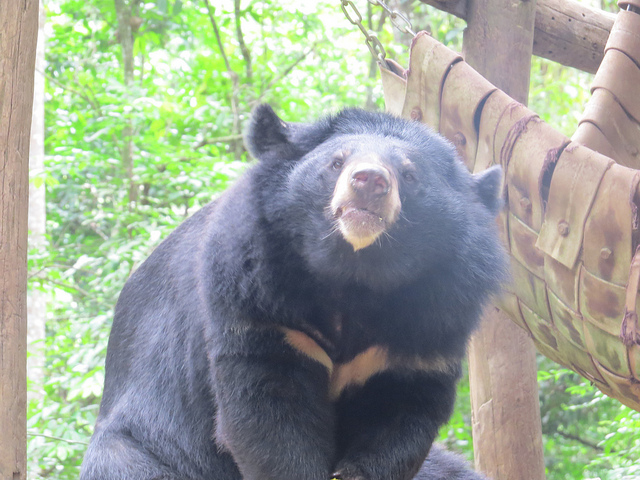

In [25]:
k = 20 #Elegir un valor de 0 a 39
j = k + 40630
Image.open(dirArray[j])

Se decodifica

In [26]:
imgDeco = Decode(Encode(y_val[k])[None,...])
# SI SE ACABA DE ENTRENAR, DESCOMENTAR ESTE imgDeco
# imgDeco = Decode(Encode(y_val[k].cuda())[None,...])

torch.Size([3, 224, 224])


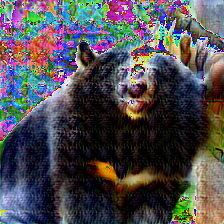

In [27]:
print(imgDeco[0].shape)
transforms.functional.to_pil_image(imgDeco[0])

Se realiza el mismo análisis con una imagen blanca

In [28]:
test = torch.full((3, 224, 224), 1, dtype = torch.float32)

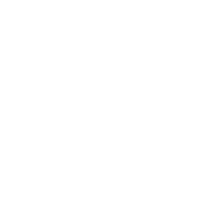

In [29]:
transforms.functional.to_pil_image(test)

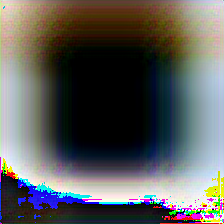

In [30]:
Test = Decode(Encode(test)[None,...])
#SI SE ACABA DE ENTRENAR, DESCOMENTAR ESTE TEST
# Test = Decode(Encode(test).cuda()[None,...])
transforms.functional.to_pil_image(Test[0])